In [2]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

In [3]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=3, doc_content_chars_max=1000)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter layers reduces performances\nfor more layers skipped, except for skipping the attention layers.\n\n

In [5]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max=1000)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [6]:
wiki.invoke('what is machine learning')

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML finds application in many fields, including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine. The application of ML to business problems is known as predictive analytics.\nStatistics and mathematical optimisation (mathematical programming) methods comprise the foundations of machine learning. Data mining is a related field of study, focusing on exploratory data analysis (EDA) via unsupervised learning. \nFrom a theoretical viewpoint, p

In [7]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

C:\Users\vibhav.ahuja\AppData\Local\Temp\ipykernel_14652\1535493036.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [9]:
tavily.invoke('provide me the recent ai news for june 2025')

[{'title': 'Latest AI Breakthroughs and News: May-June 2025 - Crescendo.ai',
  'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates',
  'content': '### Ex-OpenAI Staff Say Safety Was Sacrificed for Profit\n\nDate: June 20, 2025  \nSummary: Former OpenAI employees have accused the company of prioritizing profits over safety and transparency in a newly released letter. The letter claims OpenAI leaders ignored internal concerns and retaliated against those who raised issues. The group is calling for stronger whistleblower protections and public accountability. This adds fuel to the growing debate over AI ethics and regulation.  \nSource: AI News [...] ### Trumpâ\x80\x99s Tech Advisor Warns U.S. Not to Fall Behind China in AI\n\nDate: June 20, 2025  \nSummary: Blake Moore, a top tech advisor to Donald Trump, urged the U.S. to take aggressive action to stay ahead of China in the AI race. He warned that American complacency could lead to losing AI leadership within a decade. The 

In [10]:
tools = [arxiv, wiki, tavily]

In [11]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen-qwq-32b")

llm_with_tools=llm.bind_tools(tools)

In [12]:
from pprint import pprint
from langchain_core.messages import HumanMessage

llm_with_tools.invoke([HumanMessage(content=f'what is the recent ai news')])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. Let me see which tool would be best here. The available functions are arxiv, wikipedia, and tavily_search_results_json. \n\nArxiv is good for academic papers, but the user might want general news. Wikipedia is for encyclopedia entries, which might not be timely. Tavily\'s search results function seems like the right choice because it can provide current search results from the web.\n\nI should use tavily_search_results_json with a query like "recent AI news" to get the latest information. That should cover the latest developments, articles, or updates in AI.\n', 'tool_calls': [{'id': 'v1qm308dr', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 154, 'prompt_tokens': 268, 'total_tokens': 422, 'completion_time': 0.37948071, 'prompt_time': 0.02434623, 'queue_t

In [18]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]

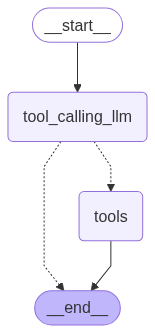

In [22]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

def tool_calling_llm(state: State):
    return {'messages':[llm_with_tools.invoke(state['messages'])]}


builder = StateGraph(State)
builder.add_node('tool_calling_llm',tool_calling_llm)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, 'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm', tools_condition)
builder.add_edge('tools', END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (bwf9ean0m)
 Call ID: bwf9ean0m
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, based
solely on attention mechanisms, dispensing with recurrence and convolutions
entirely. Experiments on two machine translation tasks show these models

In [24]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for MArch 3rd 2025")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for MArch 3rd 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (jnf1q6fmz)
 Call ID: jnf1q6fmz
  Args:
    query: top 10 recent AI news March 3rd 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Weekly AI News: 3 March 2025 - AIforBusiness.net - YouTube", "url": "https://www.youtube.com/watch?v=kw21NJ7YmZM", "content": "This week’s AI update explores some of the most impactful developments shaping technology and society. OpenAI has unveiled GPT-4.5, a cutting-edge model with enhanced intuition and emotional intelligence. While its capabilities push AI closer to human-like perception, its high computational demands raise concerns about accessibility, particularly for smaller businesses. [...] A thought-provoking

In [25]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (mywhapjtd)
 Call ID: mywhapjtd
  Args:
    query: Machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML finds application in many fields, including natural language processing, computer vision, speech recognition, email filterin